# Import library

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import scipy
import sklearn.model_selection
from sklearn.utils import shuffle
import cv2

# Display
from IPython.display import Image, display
import matplotlib.cm as cm

In [2]:
tf.__version__

'2.7.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd "/content/drive/My Drive/Study/HonorThesis/"

/content/drive/My Drive/Study/HonorThesis


# Import data

In [5]:
df = pd.read_csv (r"cycle info.csv")

In [6]:
df

,#,Comment,Pic ID,East Column,West Column,Infill,Cycle ID,MAX DISPL,MAX DRIFT,MAX FORCE,Group
0,1,NaN,DSC_0638.JPG,x,NaN,x,c7+,0.155366,0.193,122.481538,1
1,2,NaN,DSC_0639.JPG,x,NaN,x,c7+,NaN,0.193,NaN,1
2,3,angle,DSC_0641.JPG,NaN,NaN,x,c7+,NaN,0.193,NaN,1
3,4,NaN,IMG_0026.JPG,x,NaN,x,c7+,NaN,0.193,NaN,1
4,5,NaN,IMG_0027.JPG,x,NaN,x,c7+,NaN,0.193,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
152,5,NaN,IMG_0141.JPG,x,NaN,x,c25+,NaN,3.027,NaN,29
153,6,NaN,IMG_0145.JPG,flipped,NaN,NaN,c25+,NaN,3.027,NaN,29
154,7,NaN,IMG_0146.JPG,flipped,NaN,flipped,c25+,NaN,3.027,NaN,29
155,1,NaN,IMG_0142.JPG,NaN,x,NaN,c25-,-2.379716,-2.964,-75.921462,30


# Import image and data from dataframe

In [7]:
Path_Data = []
dataMaxDrift = []
imageLst = []
Str_path = 'Data1/'

In [8]:
#using the dataframe to make a path string then resize image
#and append in the list also use dataframe to append data of max drift

for i in range(df[df.columns[0]].count()):
    a = Str_path + str(df['Cycle ID'][i]) + "/" + str(df['Pic ID'][i])
    Path_Data.append(a)
    image = cv2.imread(a)
    image = cv2.resize(image, (180, 180))
    imageLst.append(image)
    b = df['MAX DRIFT'][i]
    if b < 0:
        b = abs(b)
    dataMaxDrift.append(b)

In [9]:
images = np.array(imageLst)

In [10]:
images.shape

(157, 180, 180, 3)

In [11]:
dataMaxDrift = np.array(dataMaxDrift)

In [12]:
len(dataMaxDrift)

157

In [13]:
#split data into train set and test set
split_data = sklearn.model_selection.train_test_split(images, 
                                                      dataMaxDrift,
                                                      test_size = 0.2)


In [14]:
(X_train, X_test, Y_train, Y_test) = split_data

In [15]:
X_train.shape

(125, 180, 180, 3)

In [16]:
len(Y_train)

125

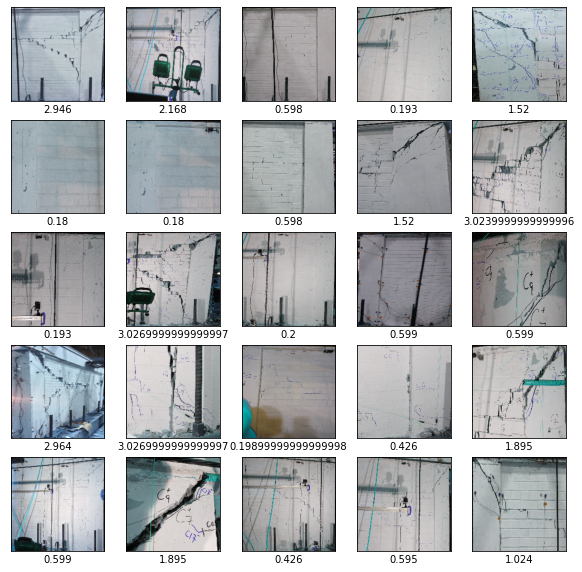

In [17]:
#example show image and corresponding data training set
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(Y_train[i])

plt.show()


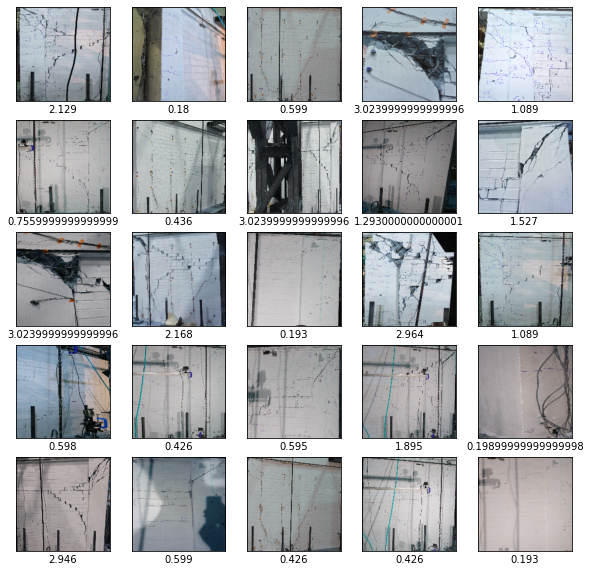

In [18]:
#example show image and corresponding data test set
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i])
    plt.xlabel(Y_test[i])

plt.show()

# Preprocessing data

In [19]:
#y_train_max = Y_train.max()
#y_test_max = Y_test.max()

#Y_train = Y_train / y_train_max
#Y_test = Y_test / y_test_max

# Build CNN layer

In [20]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.5),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05),
   
  ])

In [21]:
cnn.add(tf.keras.layers.Conv2D(filters=32,    
                               kernel_size=3, 
                               activation='relu', 
                               input_shape=[180,180, 3]))

cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))

cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))

cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))

cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Flatten())

In [22]:
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=64, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1, activation = 'linear'))

In [23]:
cnn.compile(optimizer = tf.keras.optimizers.Adam(0.001),
            loss = "mean_absolute_error",
            metrics=['mse'])

In [24]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 180, 180, 3)      0         
 rast)                                                           
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                        

In [25]:
History = cnn.fit(x = X_train , y = Y_train , validation_data = (X_test,Y_test), epochs = 100)

Epoch 1/100
4/4 [==============================] - 4s 285ms/step - loss: 1.1302 - mse: 2.1986 - val_loss: 0.8429 - val_mse: 0.9886
Epoch 2/100
4/4 [==============================] - 0s 63ms/step - loss: 0.9206 - mse: 1.3375 - val_loss: 0.7987 - val_mse: 1.2921
Epoch 3/100
4/4 [==============================] - 0s 62ms/step - loss: 0.9041 - mse: 1.4643 - val_loss: 0.7985 - val_mse: 0.9266
Epoch 4/100
4/4 [==============================] - 0s 80ms/step - loss: 0.9348 - mse: 1.1955 - val_loss: 0.7945 - val_mse: 0.8506
Epoch 5/100
4/4 [==============================] - 0s 66ms/step - loss: 0.8685 - mse: 1.3522 - val_loss: 0.7279 - val_mse: 0.8607
Epoch 6/100
4/4 [==============================] - 0s 63ms/step - loss: 0.9023 - mse: 1.3432 - val_loss: 0.7361 - val_mse: 0.7782
Epoch 7/100
4/4 [==============================] - 0s 62ms/step - loss: 0.9178 - mse: 1.1384 - val_loss: 0.6979 - val_mse: 0.7239
Epoch 8/100
4/4 [==============================] - 0s 65ms/step - loss: 0.8525 - mse: 1.3

# Visualize result after training

In [26]:
def plot_loss(history):
  plt.plot(History.history['mse'], label='msee')
  plt.plot(History.history['val_mse'], label='val_mse')
  plt.ylim([0, 1])
  plt.xlim([0,300])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

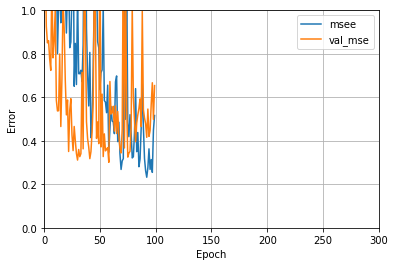

In [27]:
plot_loss(History)

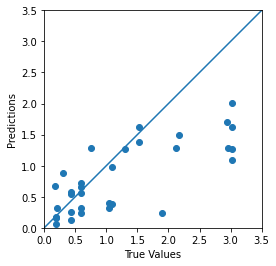

In [28]:
test_predictions = cnn.predict(X_test).flatten()
#test_predictions = list(np.concatenate(cnn.predict(images)).flat)
a = plt.axes(aspect='equal')
plt.scatter(Y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0,3.5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

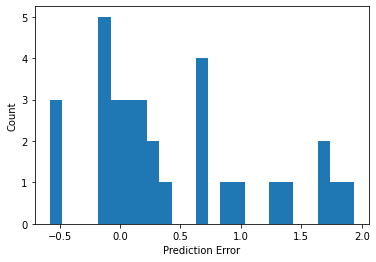

In [29]:
#test_predictions = list(np.concatenate(cnn.predict(images)).flat)
error = Y_test - np.array(test_predictions)
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

In [30]:
from sklearn.metrics import  mean_absolute_error

mean_absolute_error(np.array(Y_test),np.array(test_predictions))

0.5684304835312068

In [31]:

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [32]:
def save_and_display_gradcam(img, heatmap, alpha=0.4):
    # Load the original image
    #img = tf.keras.preprocessing.image.load_img(img_path)
    #img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))
    #display(superimposed_img)
    return superimposed_img

In [34]:
plt.figure(figsize=(40,40))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img_array = X_test[i]

    img_array = img_array.reshape(1,180,180,3)
    heatmap = make_gradcam_heatmap(img_array, cnn, "conv2d_3")

    plt.imshow(save_and_display_gradcam(X_test[i], heatmap))
    plt.xlabel(f"Actual: {Y_test[i]} Predict: {test_predictions[i]}")

plt.show()

Output hidden; open in https://colab.research.google.com to view.